<font size="6">PROJET 5 : Catégorisez automatiquement des questions </font>

<font size="6"> Notebook 2 : Modèles non supervisés </font>

**Librairies**

In [65]:
# Data analyse
import pandas as pd
import numpy as np
from pprint import pprint
from operator import itemgetter

In [66]:
# Visualisation
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [67]:
# Modèles
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from sklearn.decomposition import NMF

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

# Evaluation
from gensim.models import CoherenceModel

**Chargement des données traités dans le Notebook 1**

In [68]:
df = pd.read_pickle("./preprocess_data.pkl")

In [69]:
df

,content,preprocess_content,word_count,version-control,forms,sql,syntax,asp.net-mvc,numpy,http,...,objective-c,exception,sorting,matplotlib,c,android,ios,linq,swift,java-8
0,is there any way to tinker with the iphone sdk...,"[way, machine, plan, version, way, think, run,...",70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,i have this gigantic ugly string j transaction...,"[gigantic, ugly, string, transaction, start, p...",120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[work, autolayout, constraint, find, constrain...",199,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,i m learning objective c and keep bumping into...,"[learn, objective, keep, bump, symbol, use, di...",48,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[simple, way, pretty, standard, unix, environm...",113,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,recently i upgraded the version of django fram...,"[recently_upgrade, version, django, framework,...",331,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44991,how can i reject a promise that returned by an...,"[reject, promise, return, async_await, functio...",88,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44992,i have entities that are related as one to man...,"[entity, relate, manypublic, class, restaurant...",296,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44993,problemi want to return a file in my asp net w...,"[want, return, file, web, api, controller, app...",90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Latent Dirichlet Allocation

Principes du LDA : 

## Create the dictionary and Corpus needed for topic modeling

Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.

In [70]:
# Create Dictionary
id2word = corpora.Dictionary(df['preprocess_content'])
# Create Corpus
texts = df['preprocess_content']
# Term Document Frequancy
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2)]


In [71]:
#Exemple de mot du dictionnaire
id2word[0]

'develop'

In [72]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('develop', 1),
  ('development', 1),
  ('image', 1),
  ('iphone', 1),
  ('legal', 1),
  ('machine', 2),
  ('plan', 1),
  ('run', 2),
  ('server', 1),
  ('sure', 1),
  ('think', 1),
  ('use', 1),
  ('version', 1),
  ('vmware', 1),
  ('way', 2),
  ('window', 2)]]

## Find the optimal number of topics for LDA?

In [124]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics= num_topics, 
                                                random_state=100, 
                                                update_every=1,
                                                chunksize=200,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [125]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['preprocess_content'], 
                                                        start=9, 
                                                        limit=33, 
                                                        step=3)

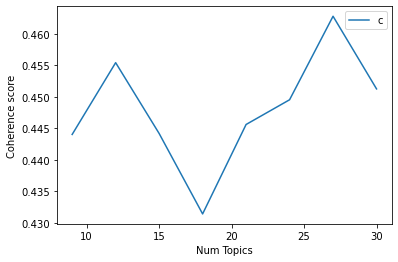

In [126]:
# Show graph
limit=33; start=9; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [127]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 9  has Coherence Value of 0.444
Num Topics = 12  has Coherence Value of 0.4554
Num Topics = 15  has Coherence Value of 0.4442
Num Topics = 18  has Coherence Value of 0.4314
Num Topics = 21  has Coherence Value of 0.4456
Num Topics = 24  has Coherence Value of 0.4496
Num Topics = 27  has Coherence Value of 0.4628
Num Topics = 30  has Coherence Value of 0.4513


In [133]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(10,
  '0.271*"image" + 0.175*"baked" + 0.083*"convert" + 0.058*"rail" + '
  '0.037*"constructor" + 0.031*"lomaxxformat" + 0.031*"literal" + '
  '0.026*"completely" + 0.017*"wise" + 0.017*"cstr"'),
 (11,
  '0.239*"least" + 0.168*"way" + 0.163*"mysql" + 0.089*"odometer" + '
  '0.055*"high" + 0.026*"monitor" + 0.026*"reference" + 0.024*"cycle" + '
  '0.018*"connection" + 0.017*"django"'),
 (26,
  '0.163*"readonly" + 0.152*"meaning" + 0.147*"initial" + 0.082*"dom" + '
  '0.073*"revert" + 0.069*"inverse" + 0.039*"vwdtempjquery" + '
  '0.033*"keithauto" + 0.026*"gravity_center" + 0.024*"hlumimplicit"'),
 (25,
  '0.181*"unit_teste" + 0.118*"object_sender" + 0.086*"session" + '
  '0.066*"notify" + 0.066*"public" + 0.046*"groovy" + 0.045*"selection" + '
  '0.027*"piece" + 0.024*"curious" + 0.021*"include"'),
 (12,
  '0.164*"server" + 0.159*"fully" + 0.144*"crash" + 0.102*"terribly" + '
  '0.088*"modern" + 0.053*"arrive" + 0.049*"unchecked" + 0.047*"fall" + '
  '0.036*"assignment" + 0.019*"pyt

**Compute Model Perplexity and Coherence Score**

In [134]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=df['preprocess_content'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.41646826002498

Coherence Score:  0.46282507112080706


## Visualize the topics-keywords

In [135]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.355207  0.118242       1        1  34.140195
4      0.123339  0.017657       2        1   6.221341
6      0.140412 -0.056229       3        1   4.443006
7      0.061118 -0.303288       4        1   4.007154
21     0.112987  0.104844       5        1   3.929400
14     0.010865  0.017918       6        1   3.279291
0      0.084842 -0.036094       7        1   3.180640
22     0.052328  0.022077       8        1   3.042705
3      0.003962  0.007671       9        1   2.996005
2      0.041414 -0.297806      10        1   2.924999
17    -0.000968  0.021536      11        1   2.839868
18     0.086713  0.105664      12        1   2.726827
19    -0.027338 -0.093169      13        1   2.693058
1     -0.035982  0.031399      14        1   2.392080
9     -0.021076  0.047703      15        1   2.224267
24    -0.037703  0.015615      16        1   2.168075
13    -0.057016  0.017351      17        1   2.153423
8     -0.056251  0.016869      18        1   2.083093
5     -0.037704  0.029594      19        1   1.964731
15    -0.078897  0.021556      20        1   1.665497
12    -0.089233  0.019510      21        1   1.558436
16    -0.070398  0.029571      22        1   1.545890
20    -0.094445  0.024314      23        1   1.511515
26    -0.109628  0.026601      24        1   1.152472
25    -0.109956  0.034309      25        1   1.090547
10    -0.126966  0.028702      26        1   1.040519
11    -0.119627  0.027884      27        1   1.024967, topic_info=                  Term          Freq         Total Category  logprob  loglift
63             default  22207.000000  22207.000000  Default  30.0000  30.0000
291          framework  18561.000000  18561.000000  Default  29.0000  29.0000
42               regex  16789.000000  16789.000000  Default  28.0000  28.0000
199             object  17020.000000  17020.000000  Default  27.0000  27.0000
31               match  14268.000000  14268.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
2304            idiomc      0.034535      1.018266  Topic27 -13.2091   1.1966
1713         intention      0.034535      1.018266  Topic27 -13.2091   1.1966
1513               sum      0.034535      1.018266  Topic27 -13.2091   1.1966
1595  position_ordinal      0.034535      1.018266  Topic27 -13.2091   1.1966
1538    findfirstindex      0.034535      1.018266  Topic27 -13.2091   1.1966

[918 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1049     15  0.983841   absolutely
1313     12  0.997871  abstraction
177       5  0.999317       access
99        1  0.999679     accessor
1314     12  0.995907      account
...     ...       ...          ...
620      21  0.977895        wrong
98       13  0.998384        xcode
353      13  0.999511      xml_sax
1138      9  0.980277         year
1404     25  0.996422       zealot

[833 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 5, 7, 8, 22, 15, 1, 23, 4, 3, 18, 19, 20, 2, 10, 25, 14, 9, 6, 16, 13, 17, 21, 27, 26, 11, 12])

**Word Cloud of Top N words in each topic**

IndexError: list index out of range

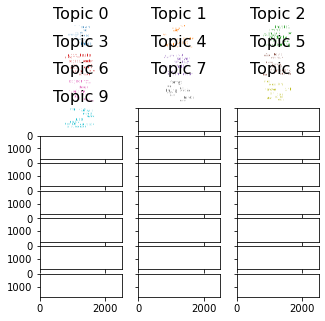

In [141]:
#Wordcloud of Top N words in each topic
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(10, 3, figsize=(5,5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Finding the dominant topic in each sentence

In [119]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['preprocess_content']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [120]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['preprocess_content'])

In [121]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3113,"use, really, uncheck, unix, vmware, catch_exce...","[way, machine, plan, version, way, think, run,..."
1,1,4.0,0.4269,"use, really, uncheck, unix, vmware, catch_exce...","[gigantic, ugly, string, transaction, start, p..."
2,2,4.0,0.3306,"use, really, uncheck, unix, vmware, catch_exce...","[work, autolayout, constraint, find, constrain..."
3,3,4.0,0.3577,"use, really, uncheck, unix, vmware, catch_exce...","[learn, objective, keep, bump, symbol, use, di..."
4,4,4.0,0.3457,"use, really, uncheck, unix, vmware, catch_exce...","[simple, way, pretty, standard, unix, environm..."
5,5,4.0,0.7069,"use, really, uncheck, unix, vmware, catch_exce...","[write, java, utility, generate, load, datum, ..."
6,6,4.0,0.3414,"use, really, uncheck, unix, vmware, catch_exce...","[need, find, format, number, string, code, ret..."
7,7,4.0,0.3161,"use, really, uncheck, unix, vmware, catch_exce...","[local, access, server, way, duplicate, clone,..."
8,8,11.0,0.3536,"least, fully, sql_server, standing, way, mysql...","[best_practice, consider, catch, exception, th..."
9,9,6.0,0.4204,"object, thing, specifically, match, bump, size...","[give, class, like, trace, functionality, log,..."


## Find the most representative document for each topic

In [122]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                   axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7752,"matching, else, suggest, image, color, partyao...",NaN
1,1.0,0.7040,"default, ampmhour, pfj, symbol, concatenate_st...","[consider, somevar, hasownproperty, someproper..."
2,2.0,0.6720,"regex, format, int, hopefully, change, actual,...","[shortcut, tell, git, push, current, tracking,..."
3,3.0,0.6837,"apple, url, always, know, additional, static, ...","[program, thing, annoy, time, take, compile, p..."
4,4.0,0.7746,"use, really, uncheck, unix, vmware, catch_exce...","[small, clone, way, want, expose, value, mini,..."
5,5.0,0.5657,"version, processworke, dualhow, classmanifest,...","[css, reason, safari, iphone, ignore, setting,..."
6,6.0,0.6792,"object, thing, specifically, match, bump, size...","[finish, read, scope, curious, assignment, man..."
7,7.0,0.6769,"framework, run, design, functionality, unix, l...",NaN
8,8.0,0.5214,"developer, distract, crash, readonly, listgood...","[come, background, understand, python, version..."
9,9.0,0.5487,"writing, copy, window, comment, drop, fulfill,...","[trouble, write, regular_expression, match, va..."


**Topic distribution across documents**

In [123]:
df_dominant_topics = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].groupby(['Dominant_Topic', 'Topic_Keywords'])['Topic_Keywords'].count().reset_index(name='Num_Documents')

df_dominant_topics['Perc_Documents'] = (df_dominant_topics['Num_Documents'])/(df_dominant_topics['Num_Documents'].sum())

df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"matching, else, suggest, image, color, partyao...",2680,0.065799
1,1.0,"default, ampmhour, pfj, symbol, concatenate_st...",1874,0.046010
2,2.0,"regex, format, int, hopefully, change, actual,...",1766,0.043359
3,3.0,"apple, url, always, know, additional, static, ...",994,0.024405
4,4.0,"use, really, uncheck, unix, vmware, catch_exce...",28053,0.688755
5,5.0,"version, processworke, dualhow, classmanifest,...",303,0.007439
6,6.0,"object, thing, specifically, match, bump, size...",1628,0.039971
7,7.0,"framework, run, design, functionality, unix, l...",2671,0.065578
8,8.0,"developer, distract, crash, readonly, listgood...",220,0.005401
9,9.0,"writing, copy, window, comment, drop, fulfill,...",277,0.006801


# Non-Negative Matrix Factorization

Principes de la NMF : 

In [ ]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


In [ ]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['preprocess_content']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(9, 33, 3))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

In [ ]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

In [ ]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
texts

In [ ]:
# Now use the number of topics with the highest coherence score to run the sklearn nmf model

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42).fit(tfidf)

In [ ]:
# Use the top words for each cluster by tfidf weight to create 'topics'

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df

In [ ]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

# Prédiction à partir d'un modèle non supervisé

In [ ]:
df.head()

## Split en train et test test

In [ ]:
# 75% random du dataset pour le train
dftrain = df.sample(frac = 0.75)

# 25% restant pour la prédiction sur data inconnue
dftest = df.drop(dftrain.index).reset_index().drop(columns = 'index')

dftrain = dftrain.reset_index().drop(columns = 'index')

In [ ]:
dftrain

In [ ]:
dftest.head()

## Entrainement du modèle

In [ ]:
# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join)

tfidf = tfidf_vectorizer.fit_transform(dftrain['preprocess_content'])

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42).fit(tfidf)

nmf

## Prédiction sur le test set (données inconnue du modèle)

In [ ]:
# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(dftest['preprocess_content'])
X_new = nmf.transform(tfidf_new)

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# Add to the df
dftest['topic_num'] = predicted_topics

dftest

In [ ]:
# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(dftrain['preprocess_content']))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

In [ ]:
# Join with the original df to get the topic summary
dfpred = pd.merge(dftest, topic_df, on='topic_num', how='left')

dfpred

# Extraire des tags à partir des résultats précédents

In [ ]:
test = dfpred.loc[dfpred['topic_num']==1]

In [ ]:
test.iloc[:,3:-2]

In [ ]:
# Nbre d'occurence des tags
sum_column1 = test.iloc[:,3:-2].sum(axis=0)
print (sum_column1.sort_values()[-5:])